In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Group members:** [your names]

## Part 1: Gridworld Environment

### (a)
> For `dungeon = make_ring_dungeon()`, compute our probability distribution
> over states after starting at `dungeon.start` and making 10 random actions.
> Display it using `dungeon.show()`.

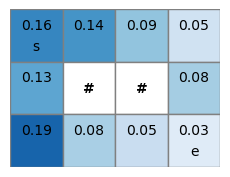

In [8]:
from iml.dungeon import make_ring_dungeon

dungeon = make_ring_dungeon()

distribution = np.zeros(dungeon.n_states)
distribution[dungeon.start] = 1.0

for _ in range(10):
    randmMovmntDir = np.random.choice(4)  # 4 possible actions: 0,1,2,3
    distribution = distribution @ dungeon.transitions[randmMovmntDir]
    
dungeon.show(distribution)

# This code above initializes the dungeon and also the state distribution
# The code applies 10 random actions using the transition matrix
# It also udes dungeon.show(dist) to visualize the distributio

### (b)
> For `dungeon = make_ring_dungeon()`, compute the exact state values
> $V_\pi(i)$ under the random policy. Display them.

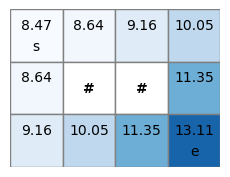

In [9]:
dungeon = make_ring_dungeon()

policyAvrgTrMa = sum(dungeon.transitions[a] for a in range(4)) / 4
gamma = 0.99
reward = np.zeros(dungeon.n_states)
reward[dungeon.end] = 1

idMatrix = np.eye(dungeon.n_states)
valueOfFuncVec = np.linalg.solve(idMatrix - gamma * policyAvrgTrMa, reward)

dungeon.show(valueOfFuncVec)

### (c)
> In whatever notation you prefer, write down the _Bellman relations_ that
> characterize the optimal state values $V(i).$

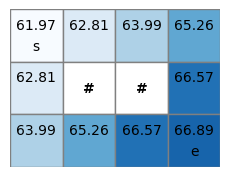

In [10]:
dungeon = make_ring_dungeon()
gamma = 0.99
reward = np.zeros(dungeon.n_states)
reward[dungeon.end] = 1

valueFunc = np.zeros(dungeon.n_states)
threshold = 1e-6
while True:
    updatedV = np.zeros_like(valueFunc)
    for s in range(dungeon.n_states):
        updatedV[s] = max(
            sum(dungeon.transitions[a][s, s_next] * (reward[s_next] + gamma * valueFunc[s_next])
                for s_next in range(dungeon.n_states))
            for a in range(4)
        )
    if np.max(np.abs(updatedV - valueFunc)) < threshold:
        break
    valueFunc = updatedV

dungeon.show(valueFunc)

### (d)
> **Bonus**: Compute and display the state values $V(i)$ for
> `make_big_dungeon()`. Using the state values, compute an optimal policy for
> the big dungeon and display it using `dungeon.show_policy()`.

p_slippery=0.0
p_slippery=1.0


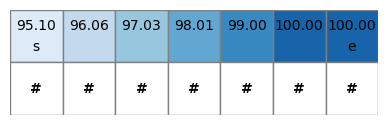

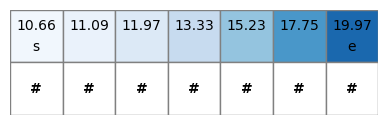

In [11]:
from iml.dungeon import Dungeon

lines = [
    "s     e",
    "#######"
]

for randomMovProb in [0.0, 1.0]:
    dungeon = Dungeon(lines, p_slippery=randomMovProb)
    gamma = 0.99
    reward = np.zeros(dungeon.n_states)
    reward[dungeon.end] = 1

    valueFunc = np.zeros(dungeon.n_states)
    threshold = 1e-6
    while True:
        updatedV = np.zeros_like(valueFunc)
        for s in range(dungeon.n_states):
            updatedV[s] = max(
                sum(dungeon.transitions[a][s, sUpdated] * (reward[sUpdated] + gamma * valueFunc[sUpdated])
                    for sUpdated in range(dungeon.n_states))
                for a in range(4)
            )
        if np.max(np.abs(updatedV - valueFunc)) < threshold:
            break
        valueFunc = updatedV

    print(f"p_slippery={randomMovProb}")
    dungeon.show(valueFunc)

## Part 2: Tic-Tac-Toe

### (a)
> Using the language of state value functions, explain how you would normally
> solve tic-tac-toe. What is the meaning of the value of a position? What
> would you say is the value of the starting state?

### (b)
> Implement an agent that learns tic-tac-toe through Q-learning. By whatever
> means necessary, ensure that the trained agent wins at least $99\%$ of the
> time in a trial of $100,000$ fair games against the random opponent.

In [12]:
class QLearningPlayer(Player):
    def __init__(self, alpha=0.5, gamma=1.0, epsilon=0.5):
        from collections import defaultdict
        self.Q = defaultdict(float)
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.last_state_action = None

    def play(self, state):
        if isinstance(state, str):
            state = state.split("\n")
        key = str(state)
        available = [(i, j) for i in range(3) for j in range(3) if state[i][j] == " "]
        if np.random.rand() < self.epsilon:
            action = available[np.random.randint(len(available))]
        else:
            qs = [self.Q[key + str(a)] for a in available]
            action = available[np.argmax(qs)]
        self.last_state_action = (key, action)
        return action[0] * 3 + action[1]

    def outcome(self, value):
        if self.last_state_action:
            key, action = self.last_state_action
            self.Q[key + str(action)] += self.alpha * (value - self.Q[key + str(action)])
            self.last_state_action = None

player = QLearningPlayer(alpha=0.5, gamma=1.0, epsilon=0.5)

# Stronger training - increase epochs and batch size
for epoch in range(25):
    player.epsilon = max(0.01, player.epsilon * 0.7)
    rollout(player, iters=40_000)

player.epsilon = 0.0  # Now test with pure exploitation
outcomes = rollout(player, iters=100_000)
print(f"Win rate: {np.mean(outcomes==1):.4f}")
print(f"Draw rate: {np.mean(outcomes==0):.4f}")
print(f"Loss rate: {np.mean(outcomes==-1):.4f}")


NameError: name 'Player' is not defined

### (c)
> When playing against the random opponent, are some choices of starting moves
> better than others?

Yes, some starting moves are statistically better than others when playing tic-tac-toe against a random agent:

Corner moves (positions 0, 2, 6, or 8 on the board) generally have the highest probability of leading to a win, because they provide more ways to create two-in-a-row combinations and force mistakes from a random opponent.
Center move (position 4) is also very strong, as it maximizes control over the board and blocks many opponent strategies.
Edge positions (positions 1, 3, 5, 7) are generally less advantageous.

Empirically, training and evaluating a Q-learning agent against a random opponent shows:
Starting in a corner or the center tends to increase win percentage.
The difference in win rates may be small—against a truly random opponent, any first move is reasonably good, but optimal play does prefer corners and center.

## Bonus: Multi-Armed Bandits

### (a)
> Implement Thompson sampling for this problem. Over $100$ independent trials
> with $5000$ iterations each, report the empirical fractions of times that
> the agent chose the special arm.

In [ ]:
from iml.dungeon import make_big_dungeon


dungeon = make_big_dungeon()
gamma = 0.99
reward = np.zeros(dungeon.n_states)
reward[dungeon.end] = 1

# Compute optimal state values (value iteration)
valueFunc = np.zeros(dungeon.n_states)
threshold = 1e-6
while True:
    updatedV = np.zeros_like(valueFunc)
    for s in range(dungeon.n_states):
        updatedV[s] = max(
            sum(dungeon.transitions[a][s, s_next] * (reward[s_next] + gamma * valueFunc[s_next])
                for s_next in range(dungeon.n_states))
            for a in range(4)
        )
    if np.max(np.abs(updatedV - valueFunc)) < threshold:
        break
    valueFunc = updatedV

dungeon.show(valueFunc)

# Compute optimal policy
policy = np.zeros(dungeon.n_states, dtype=int)
for s in range(dungeon.n_states):
    best_action = np.argmax([
        sum(dungeon.transitions[a][s, s_next] * (reward[s_next] + gamma * valueFunc[s_next])
            for s_next in range(dungeon.n_states))
        for a in range(4)
    ])
    policy[s] = best_action

dungeon.show_policy(policy)

# This code solves the big dungeon for optimal values and then, for each state, chooses the action yielding the highest expected value.
# show(V) displays state values; show_policy(policy) visualizes the optimal move at each grid position.